In [ ]:
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Baca daftar kata dari file txt
with open("data\\indonesian-words.txt") as f:
    words = [w.strip() for w in f.readlines() if w.strip()]

alphabet = "abcdefghijklmnopqrstuvwxyz"
random.seed(42)

def mutate(word):
    word = list(word)
    ops = random.randint(1, 3)

    for _ in range(ops):
        op = random.choice(["insert", "delete", "substitute"])

        if op == "insert":
            pos = random.randint(0, len(word))
            char = random.choice(alphabet)
            word.insert(pos, char)

        elif op == "delete" and len(word) > 1:
            pos = random.randint(0, len(word)-1)
            word.pop(pos)

        elif op == "substitute":
            pos = random.randint(0, len(word)-1)
            char = random.choice(alphabet)
            word[pos] = char

    return "".join(word)

# Buat 1000 pasangan
pairs = []
for i in range(1000):
    Rill = random.choice(words)
    Fake = mutate(Rill)
    pairs.append([Rill, Fake])

# Simpan ke CSV
with open("Rill-Fake dataset.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Rill", "Fake"])
    writer.writerows(pairs)

print("Dataset selesai dibuat! Total pasangan:", len(pairs))

Dataset selesai dibuat! Total pasangan: 1000


In [3]:
def greedy_edit_distance(a, b):
    i = 0
    j = 0
    dist = 0

    len_a = len(a)
    len_b = len(b)

    # Loop dua pointer
    while i < len_a and j < len_b:

        # Kalau huruf sama, tinggal geser
        if a[i] == b[j]:
            i += 1
            j += 1

        else:
            # RULE 1: delete a[i] jika a[i+1] == b[j]
            if i + 1 < len_a and a[i + 1] == b[j]:
                i += 1
                dist += 1

            # RULE 2: insert b[j] jika a[i] == b[j+1]
            elif j + 1 < len_b and a[i] == b[j + 1]:
                j += 1
                dist += 1

            # RULE 3: substitute
            else:
                i += 1
                j += 1
                dist += 1

    # Tambahkan sisa karakter yang belum diproses
    dist += (len_a - i)
    dist += (len_b - j)

    return dist



In [4]:
def edit_distance_dp(a, b):
    n = len(a)
    m = len(b)

    dp = [[0] * (m + 1) for _ in range(n + 1)]

    # Base case
    for i in range(n + 1):
        dp[i][0] = i

    for j in range(m + 1):
        dp[0][j] = j

    # DP table fill
    for i in range(1, n + 1):
        for j in range(1, m + 1):

            cost = 0 if a[i - 1] == b[j - 1] else 1

            dp[i][j] = min(
                dp[i - 1][j] + 1,        # delete
                dp[i][j - 1] + 1,        # insert
                dp[i - 1][j - 1] + cost  # substitute
            )

    return dp[n][m], dp


In [5]:
import pandas as pd

# Baca dataset kamu
df = pd.read_csv("Rill-Fake dataset.csv")
df["Rill"] = df["Rill"].fillna("").astype(str)
df["Fake"] = df["Fake"].fillna("").astype(str)

# Tambahkan kolom baru
df["greedy"] = df.apply(lambda row: greedy_edit_distance(row["Rill"], row["Fake"]), axis=1)
df["dp"] = df.apply(lambda row: edit_distance_dp(row["Rill"], row["Fake"])[0], axis=1)
df["selisih"] = df["greedy"] - df["dp"]

# Simpan hasil
df.to_csv("results.csv", index=False)

print("Selesai! Hasil disimpan ke results.csv")

Selesai! Hasil disimpan ke results.csv


In [6]:
mistakes = df[df["greedy"] != df["dp"]]
mistakes.to_json("greedy_mistakes.json", index=False)

print("Total kasus greedy salah:", len(mistakes))


Total kasus greedy salah: 93


In [8]:
import time
# --- 2. LOAD DATASET ---
try:
    df = pd.read_csv("Rill-Fake dataset.csv")
    # Make sure 'n' column exists, if not, create it from 'Rill' length
    if 'n' not in df.columns:
        df['n'] = df['Rill'].str.len()
    print("Dataset berhasil dimuat.")
except FileNotFoundError:
    # Fallback jika file belum ada (untuk testing)
    print("Warning: File CSV tidak ditemukan. Menggunakan data dummy.")
    df = pd.DataFrame({'Rill': ['test']*100, 'Fake': ['test']*100, 'n': [5]*100}) # Changed 'n_avg' to 'n'

# --- 3. EXPERIMENT RUNNER (MODIFIKASI) ---
def run_benchmark():
    random.seed(42)

    # KITA UBAH SIZE MENJADI MAKSIMAL 15 (Sesuai dataset kita)
    sizes = [3, 6, 9, 12, 15]

    print(f"\n{'n':<5} | {'Metode':<10} | {'Waktu Rata-rata (ms)':<20} | {'Gap (%)':<10}")
    print("-" * 55)

    t_greedy_times = []
    t_dp_times = []
    gap_percentages = []

    for n in sizes:
        # --- MODIFIKASI: AMBIL DARI DATASET ---
        # Kita ambil data yang panjang rata-ratanya mendekati n (toleransi \u00b1 1.5)
        subset = df[ (df['n'] >= n - 1.5) & (df['n'] <= n + 1.5) ] # Changed 'n_avg' to 'n'

        # Ambil sampel 50 data (atau semua jika kurang dari 50)
        n_sample = min(50, len(subset))
        if n_sample == 0:
            print(f"Warning: Tidak ada data untuk ukuran n={n}")
            continue

        sample_data = subset.sample(n_sample, random_state=42)
        test_data = list(zip(sample_data['Rill'], sample_data['Fake']))
        # --------------------------------------

        for name, func in [("Greedy", greedy_edit_distance), ("DP", edit_distance_dp)]:
            times = []
            results = []

            for a, b in test_data:
                # 20 kali ulangan per instance sesuai metodologi
                start = time.perf_counter()
                for _ in range(20):
                    res = func(str(a), str(b)) # Pastikan string
                end = time.perf_counter()

                times.append(((end - start) / 20) * 1000)

                # Handling return type (DP returns tuple, Greedy returns int)
                if name == "DP":
                    results.append(res[0])
                else:
                    results.append(res)

            avg_time = sum(times) / len(times)

            # Hitung Gap (khusus Greedy dibanding DP)
            if name == "Greedy":
                # Hitung solusi optimal (DP) untuk dataset ini sebagai baseline
                opt_res_raw = [edit_distance_dp(str(a), str(b)) for a, b in test_data]
                opt_res = [val[0] for val in opt_res_raw]

                # Hindari pembagian dengan nol
                total_opt = sum(opt_res)
                if total_opt == 0:
                    gap = 0
                else:
                    gap = sum([abs(results[i]-opt_res[i]) for i in range(len(results))]) / total_opt * 100

                gap_percentages.append(gap)
                t_greedy_times.append(avg_time)
                print(f"{n:<5} | {name:<10} | {avg_time:<20.6f} | {gap:<10.2f}%")
            else:
                t_dp_times.append(avg_time)
                print(f"{n:<5} | {name:<10} | {avg_time:<20.6f} | {'0.00%':<10}")

        print("-" * 55)

    return sizes, t_greedy_times, t_dp_times, gap_percentages

# Jalankan Benchmark
sizes, t_greedy, t_dp, gap_results = run_benchmark()

Dataset berhasil dimuat.

n     | Metode     | Waktu Rata-rata (ms) | Gap (%)   
-------------------------------------------------------
3     | Greedy     | 0.000907             | 2.04      %
3     | DP         | 0.005411             | 0.00%     
-------------------------------------------------------
6     | Greedy     | 0.001194             | 9.47      %
6     | DP         | 0.011912             | 0.00%     
-------------------------------------------------------
9     | Greedy     | 0.001062             | 12.50     %
9     | DP         | 0.021218             | 0.00%     
-------------------------------------------------------
12    | Greedy     | 0.001304             | 38.30     %
12    | DP         | 0.034504             | 0.00%     
-------------------------------------------------------
15    | Greedy     | 0.001823             | 20.00     %
15    | DP         | 0.037275             | 0.00%     
-------------------------------------------------------


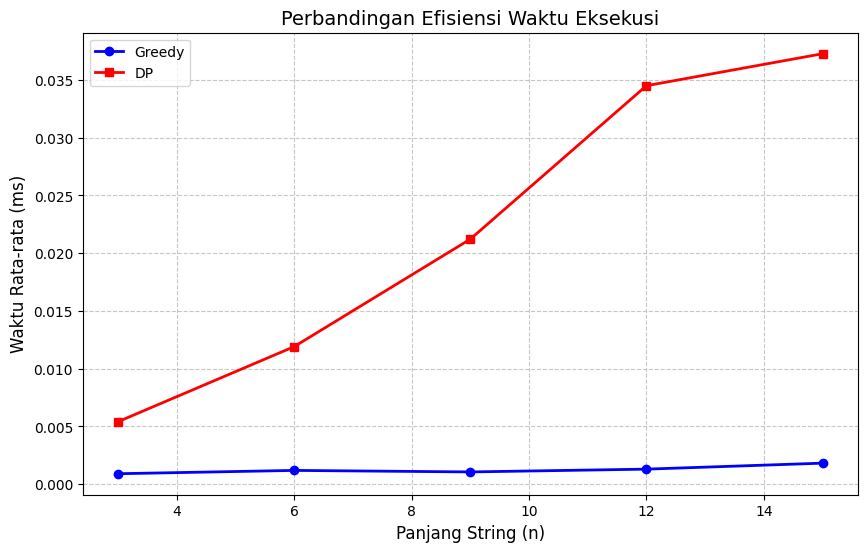

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, t_greedy, 'b-o', linewidth=2, label='Greedy' )
plt.plot(sizes, t_dp, 'r-s', linewidth=2, label='DP' )

plt.title("Perbandingan Efisiensi Waktu Eksekusi", fontsize=14)
plt.xlabel("Panjang String (n)", fontsize=12)
plt.ylabel("Waktu Rata-rata (ms)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

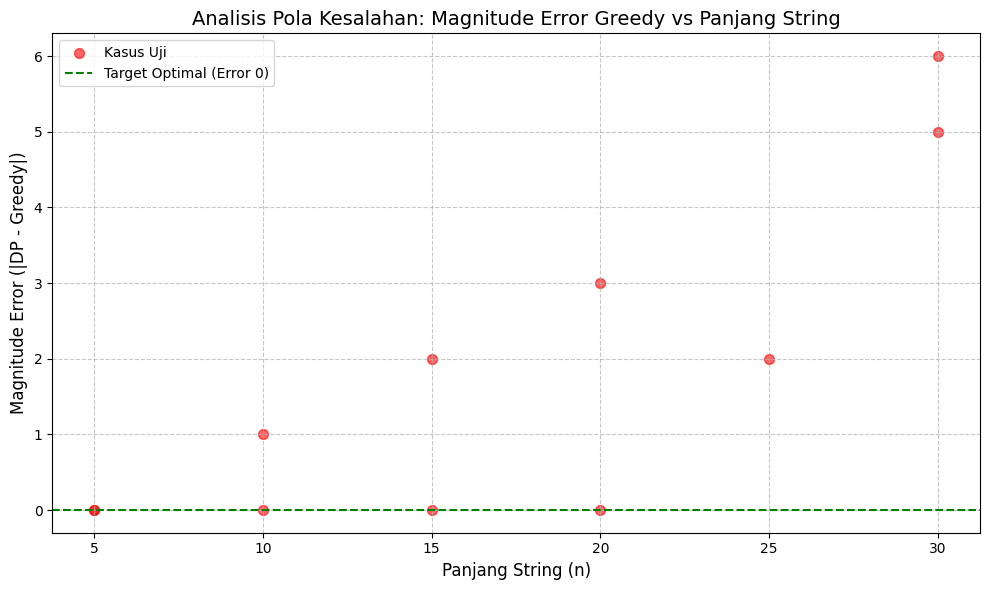

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# --- DATA CONTOH (Ganti dengan data riil Anda) ---
# Pastikan panjang ketiga array ini sama!
n_values = np.array([5, 5, 10, 10, 15, 15, 20, 20, 25, 30, 30])
dp_results = np.array([2, 3, 5, 8, 7, 10, 12, 15, 18, 20, 22])
greedy_results = np.array([2, 3, 6, 8, 7, 12, 15, 15, 20, 25, 28])

# --- MENGHITUNG MAGNITUDE ERROR ---
# Error absolut = |Optimal - Greedy|
errors = np.abs(dp_results - greedy_results)

# --- MEMBUAT VISUALISASI ---
plt.figure(figsize=(10, 6))

# Plot titik-titik error
# Gunakan 'alpha' agar jika ada titik bertumpuk terlihat lebih tebal
plt.scatter(n_values, errors, color='red', alpha=0.6, s=50, label='Kasus Uji')

# Menambahkan garis referensi di Error = 0 (Kasus di mana Greedy Optimal)
plt.axhline(y=0, color='green', linestyle='--', linewidth=1.5, label='Target Optimal (Error 0)')

# Dekorasi Grafik
plt.title('Analisis Pola Kesalahan: Magnitude Error Greedy vs Panjang String', fontsize=14)
plt.xlabel('Panjang String (n)', fontsize=12)
plt.ylabel('Magnitude Error (|DP - Greedy|)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

Visualisasi ini berhasil membuktikan trade-off (pertukaran) antara efisiensi dan akurasi. Meskipun pada grafik sebelumnya Greedy terbukti jauh lebih cepat secara waktu, grafik ini memperingatkan bahwa untuk data yang panjang dan kompleks, penggunaan Greedy berisiko memberikan hasil yang sangat tidak akurat dibandingkan DP.

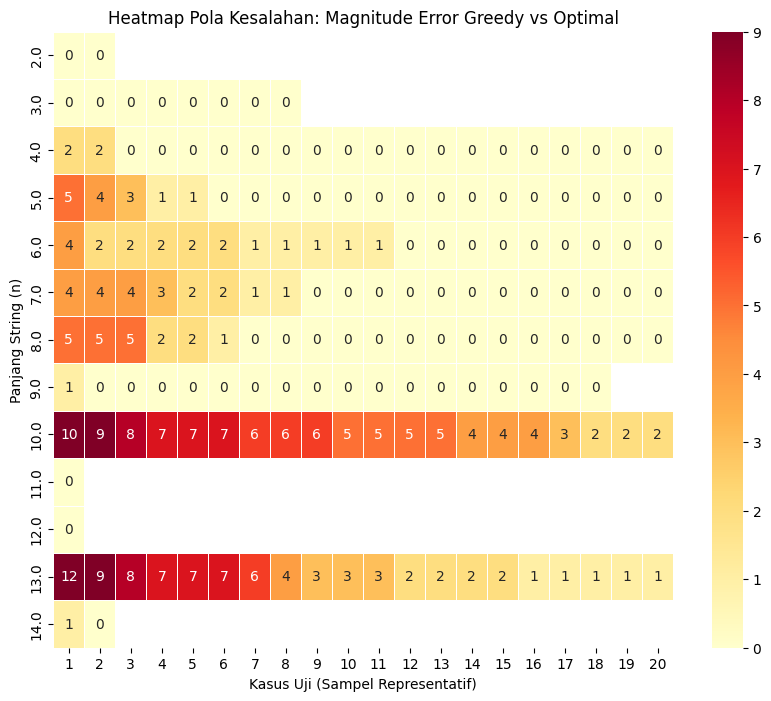

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Memuat data asli dari 1000 entri
df = pd.read_csv('results.csv')
df['n'] = df['Rill'].str.len()


# Mengelompokkan berdasarkan panjang (n) dan mengambil kasus dengan error tertinggi
df_sample = df.sort_values(['n', 'selisih'], ascending=[True, False]).groupby('n').head(20)
df_sample['Sampel'] = df_sample.groupby('n').cumcount() + 1

# Pivot untuk Heatmap
pivot_map = df_sample.pivot(index='n', columns='Sampel', values='selisih')

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_map, annot=True, cmap='YlOrRd', vmin=0, vmax=9, linewidths=.5)
plt.title('Heatmap Pola Kesalahan: Magnitude Error Greedy vs Optimal')
plt.ylabel('Panjang String (n)')
plt.xlabel('Kasus Uji (Sampel Representatif)')
plt.show()

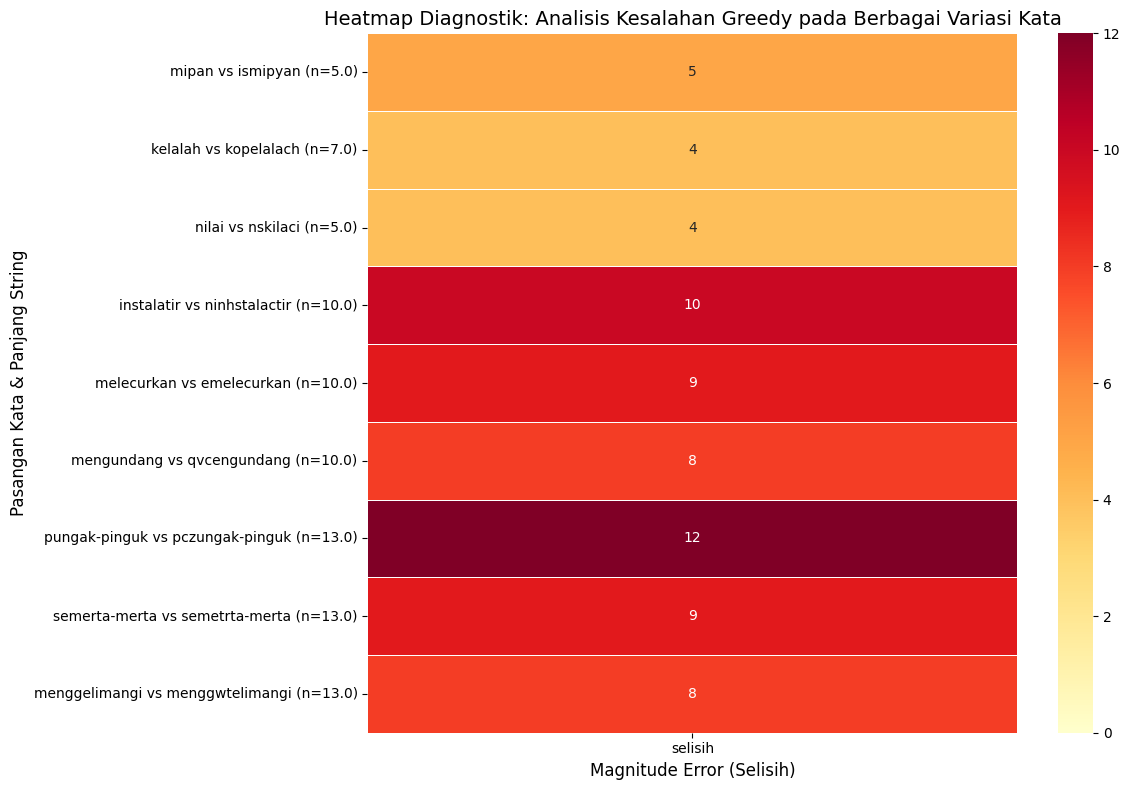

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load data riil Anda
df = pd.read_csv('results.csv')
df['n'] = df['Rill'].str.len()

# 2. Ambil sampel bervariasi secara otomatis
# Kita ambil 2 sampel terbaik untuk setiap rentang panjang agar terlihat variasinya
samples = []
for r in [(0,7), (8,12), (13,15), (16,30)]:
    subset = df[(df['n'] >= r[0]) & (df['n'] <= r[1])]
    if not subset.empty:
        # Ambil yang selisihnya paling besar di rentang tersebut
        samples.append(subset.sort_values('selisih', ascending=False).head(3))

df_final = pd.concat(samples)

# 3. Buat Label Gabungan untuk Sumbu Y
df_final['Kasus_Uji'] = df_final['Rill'] + " vs " + df_final['Fake'] + " (n=" + df_final['n'].astype(str) + ")"

# 4. Plotting Heatmap
plt.figure(figsize=(12, 8))
plot_data = df_final.set_index('Kasus_Uji')[['selisih']]

sns.heatmap(plot_data, annot=True, cmap='YlOrRd', vmin=0, vmax=12, linewidths=.5)

plt.title('Heatmap Diagnostik: Analisis Kesalahan Greedy pada Berbagai Variasi Kata', fontsize=14)
plt.ylabel('Pasangan Kata & Panjang String', fontsize=12)
plt.xlabel('Magnitude Error (Selisih)', fontsize=12)
plt.tight_layout()
plt.show()